# Tutorial for REU data processing and visualization

**Authors: Yu Huang, Sungduk Yu**

It is an introductory tutorial for a demo dataset from the climate model [E3SM-MMF](https://www.exascaleproject.org/research-project/e3sm-mmf/). See [E3SM](https://e3sm.org/wp-content/uploads/2021/11/E3SM_Brochure-2021.pdf) for more information.

This notebook includes preprocessing of the unstructured data, which cannot be managed by xarray directly, and visualization of climate variables. 

The goal is to practice the skills covered during Week1 of the bootcamp to carry out climate analysis, and to get more familiar with the climate concepts using the REU dataset.


## Data preprocessing
### Install and load python packages

Please click the "+" button on the leftup corner to launch a terminal, copy the below commands after "!" and run them on the terminal if you cannot directly import them

In [1]:
# ! mamba install -y pynco pynio pyngl

In [2]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from nco import Nco
from tqdm import tqdm
import Ngl
import xesmf as xe

### Load dataset from Google Cloud

#### Open Google Cloud Storage File System


In [3]:
fs = gcsfs.GCSFileSystem()

#### List files in the bucket where the E3SM-MMF dataset is stored


In [4]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.test.output.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

#### Open the file you want using xarray


In [5]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds = xr.open_dataset(mapper, engine='zarr')


#### Check which variables are included & their dimensions/shapes 

Use [E3SM-MMF Dataset Variable List](https://docs.google.com/spreadsheets/d/1ljRfHq6QB36u0TuoxQXcV4_DSQUR0X4UimZ4QHR8f9M/edit#gid=0) to check the physical meaning of each variable.

Check the original data coordinates first. Instead of using time, latitude, longitude as the coordinates, the raw data uses **sample**(time step) and **ncol**(column index).


In [6]:
ds

<xarray.Dataset>
Dimensions:         (sample: 210240, ncol: 384, lev: 60)
Dimensions without coordinates: sample, ncol, lev
Data variables: (12/16)
    cam_out_FLWDS   (sample, ncol) float64 ...
    cam_out_NETSW   (sample, ncol) float64 ...
    cam_out_PRECC   (sample, ncol) float64 ...
    cam_out_PRECSC  (sample, ncol) float64 ...
    cam_out_SOLL    (sample, ncol) float64 ...
    cam_out_SOLLD   (sample, ncol) float64 ...
    ...              ...
    state_q0003     (sample, lev, ncol) float64 ...
    state_t         (sample, lev, ncol) float64 ...
    state_u         (sample, lev, ncol) float64 ...
    state_v         (sample, lev, ncol) float64 ...
    tod             (sample) int32 ...
    ymd             (sample) int32 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Reorganize the temporal dimension/coordinate

#### Add the *time* dimension  
Originally the time information is coded in the variables **ymd** and **tod**. The **sample** index represents the time step count. 

**ymd** includes date information: the first digit indicates the index of year, the next two digits indicate the month and the last three digits indicates the calendar day in the year.

**tod** represents time in the day counted in seconds.

In [7]:
ds.ymd.values[0], ds.tod.values[0]

(10201, 0)

In [8]:
# loop over all sample points
year=ds['ymd']//10000
month=ds['ymd']%10000//100
day=ds['ymd']%10000%100
hour=ds['tod']//3600
minute=ds['tod']%3600//60

k=0
t = []
for k in range(len(ds['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds['sample'] = t
ds = ds.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds = ds.drop(['tod','ymd'])

# Check the current **time** dimension, read the timestep
ds.time.values[0:5]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True)],
      dtype=object)

#### Reduce the data size/coarse the time resolution 

The **time** dimension is large. For avoid memory issues, currently we'll keep only one sample each day. 

You can take the daily/monthly mean/max/min data or the data at a specific time each day. 

There are many ways to do that. You can uncomment the codes to try.

In [9]:
# keep a copy of the original data at 20-min time step and gridded by column index
ds_origin = ds.copy()

# 1. tried to resample the whole dataset but then the memory blows up
# ds = ds.resample(time='1D').mean('time')
# ds

# 2. select data at noon per day for the whole dataset
# itime = np.arange(36,len(ds.time),24*3)
# ds = ds.isel(time = itime)
# ds

I can continue taking the monthly mean using *resample* function, which will further reduce the data size. It requires more memory so I only process two 2D variables here *total precipitation* and *net surface shortwave radiation*.

In [11]:
# resample the data to be monthly instead of daily
# first do the transformation so we have: total precipitation = snow + rainfall

ds['cam_out_PRECT'] = ds['cam_out_PRECC'] + ds['cam_out_PRECSC']
ds = ds[['cam_out_PRECT', 'cam_out_NETSW']].resample(time='1M').mean(dim='time')
ds

<xarray.Dataset>
Dimensions:        (time: 96, ncol: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
Dimensions without coordinates: ncol
Data variables:
    cam_out_PRECT  (time, ncol) float64 1.826e-09 1.298e-08 ... 3.901e-08
    cam_out_NETSW  (time, ncol) float64 291.1 247.9 252.8 ... 34.52 57.44 76.93
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

### Remap and interpolate the data so that they have structured lat, lon coordinates

#### Open a file that stores grid information, and check the original lat, lon information

In [12]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

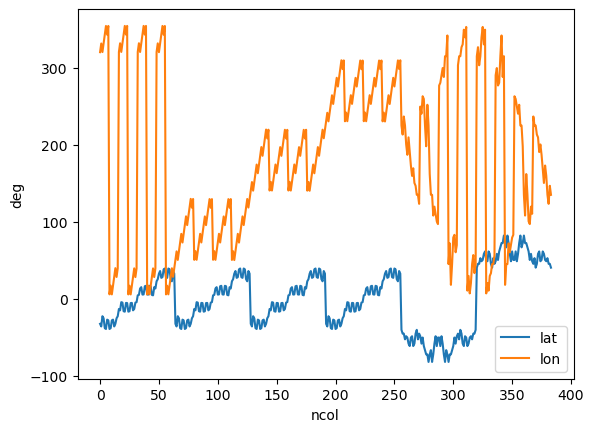

In [13]:
fig, ax = plt.subplots()
ds_grid['lat'].plot(label='lat', ax=ax)
ds_grid['lon'].plot(label='lon', ax=ax)
ax.set_ylabel('deg')
ax.legend()

In [14]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

#### Change the geo-coordinate from column index to multi-index (lat, lon) and see what the data looks like

In [15]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = ds.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# set multi-index for the original dataset using lat and lon
ds_multiindex = ds_multiindex.set_index(index_id=["lat", "lon"])
index_id = ds_multiindex.index_id
ds_multiindex = ds_multiindex.drop('index_id')
ds_multiindex = ds_multiindex.rename({'ncol':'index_id'})
ds_multiindex = ds_multiindex.assign_coords(index_id = index_id)
ds_multiindex

<xarray.Dataset>
Dimensions:        (time: 96, index_id: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat            (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
  * lon            (index_id) float64 320.3 331.5 320.4 ... 123.3 146.7 135.0
  * index_id       (index_id) object MultiIndex
Data variables:
    cam_out_PRECT  (time, index_id) float64 1.826e-09 1.298e-08 ... 3.901e-08
    cam_out_NETSW  (time, index_id) float64 291.1 247.9 252.8 ... 57.44 76.93
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [21]:
# create a dataset with stacked (lat, lon) grids in the original dataset, all values are NaNs
time = ds.time.values

data_np = np.empty(shape=(len(time), len(np.unique(lat)),len(np.unique(lon))))
data_np[:,:] = np.nan

ds_latlon = xr.Dataset(
     data_vars={
         # v: (("time","index_id"), np.zeros([len(time), len(np.unique(lat))*len(np.unique(lon))]))
         v: (("time","lat","lon"), data_np)
         for v in ['cam_out_NETSW','cam_out_PRECT']
     },
     coords={
         "time": ds.time,
         # "index_id": pd.MultiIndex.from_product(
         #    [np.unique(lat), np.unique(lon)], names=["lat", "lon"],),
         "lat": np.unique(lat),
         "lon": np.unique(lon),
         # "lev": ds.lev,
    },
)

# use multi-index so that we can assign the column data to the (lat,lon) data
ds_latlon = ds_latlon.stack(index_id=['lat','lon'])
ds_latlon 

# print(len(ds_multiindex.index_id.values))
# ds_latlon.sel(index_id=(-32.59, 320.27))

<xarray.Dataset>
Dimensions:        (time: 96, index_id: 9360)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * index_id       (index_id) object MultiIndex
  * lat            (index_id) float64 -82.06 -82.06 -82.06 ... 82.06 82.06 82.06
  * lon            (index_id) float64 5.63 5.65 5.68 5.73 ... 354.3 354.4 354.4
Data variables:
    cam_out_NETSW  (time, index_id) float64 nan nan nan nan ... nan nan nan nan
    cam_out_PRECT  (time, index_id) float64 nan nan nan nan ... nan nan nan nan

100%|██████████| 384/384 [00:00<00:00, 582.77it/s]


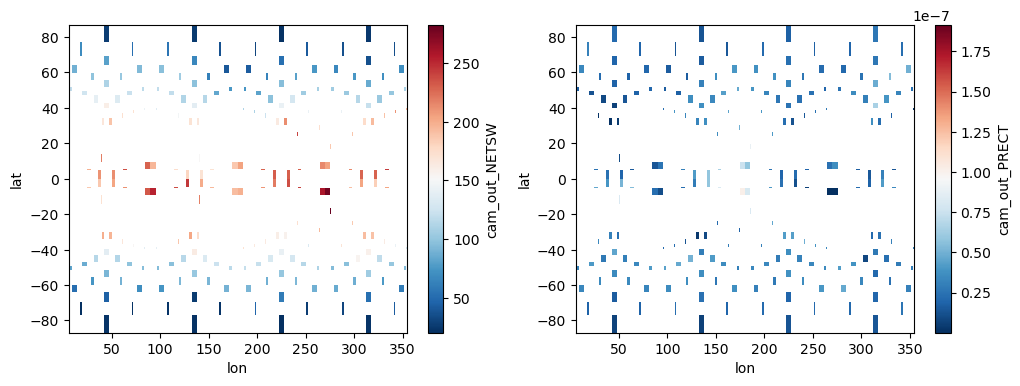

In [23]:
# use tqdm to visualize the progress of the below loop
# this cell takes about 20min to run, please patiently wait when it is run
ds_precc = ds_latlon.cam_out_PRECT.copy()
ds_netsw = ds_latlon.cam_out_NETSW.copy()

for i in tqdm(ds_multiindex.index_id.values):
    # ds_latlon.loc[{"index_id": i}] = ds_multiindex[[' cam_out_NETSW','cam_out_PRECC']].sel(index_id = i) 
    #### wrong, will lead to all vars have the same values
    ds_precc.loc[{"index_id": i}] = ds_multiindex['cam_out_PRECT'].sel(index_id = i)
    ds_netsw.loc[{"index_id": i}] = ds_multiindex['cam_out_NETSW'].sel(index_id = i)

ds_latlon['cam_out_PRECT'] = ds_precc.copy()
ds_latlon['cam_out_NETSW'] = ds_netsw.copy()

ds_unstack = ds_latlon.unstack('index_id')
ds_unstack

## if we directly visualize the 2D maps, then there are many missing values 
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_unstack. cam_out_NETSW.mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_unstack.cam_out_PRECT.mean('time').plot(cmap='RdBu_r',ax=ax[1])

<span style="color:blue"> **Look, the raw dataset is visualized weirdly directly using xarray because it is on an unstructured grid. See [page 9](https://www.osti.gov/servlets/purl/1807356) to know more about the raw grid setup.**</span>

#### Use [pynco](https://pynco.readthedocs.io/en/stable/) to remap data on the unstructured grid to a structured grid 

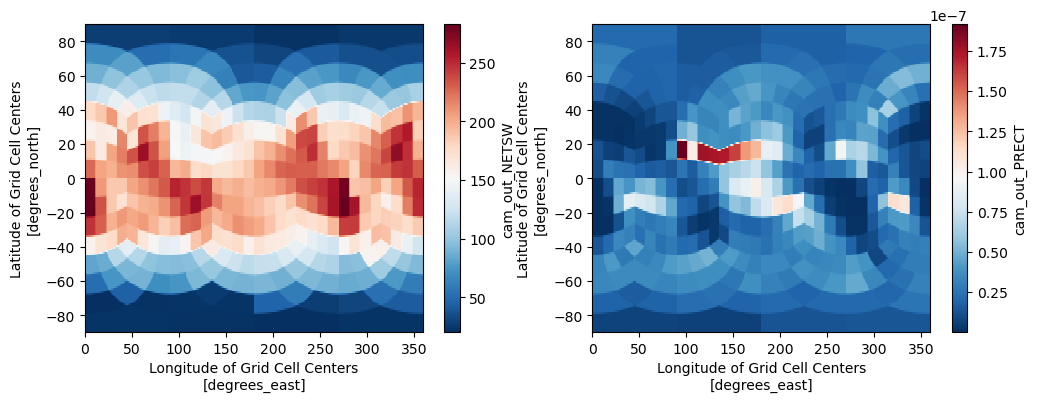

In [25]:
infile = '../E3SM-MMF_ne4_train_output_monthly_raw.nc'
outfile = '../E3SM-MMF_ne4_train_output_monthly_remap.nc'
#Mapfile to convert unstructured data to gridded data
mapfile = '../map_ne4pg2_to_180x360_aave.20220722.nc'

ds.to_netcdf('../E3SM-MMF_ne4_train_output_monthly_raw.nc')

nco = Nco()
nco.ncks(input=infile, output=outfile, map=mapfile)

ds_remap = xr.open_dataset(outfile)

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_remap['cam_out_NETSW'].mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_remap['cam_out_PRECT'].mean('time').plot(cmap='RdBu_r',ax=ax[1])

#### Interpolate the unstructured data at 2-deg resolution

For simplicity and memory consideration, we use a tool [PyNGL](https://www.pyngl.ucar.edu/Functions/Ngl.natgrid.shtml) to interpolate the **RAW** data to make it structured on the grid we want, so that we can make some climate analysis using the skills you learned earlier this week. 


In [26]:
# original lat and lon info
ncol = ds.ncol.values

# new lat and lon grids that we finally want
nlat = np.arange(-90, 90.5, 2)
nlon = np.arange(0, 360, 2)

# create a nan-value xr dataset to contain new remapped & interpolated data 
data_var = np.empty([len(time), len(nlat), len(nlon)])
data_var[:,:,:] = np.nan

ds_new = xr.Dataset(
     data_vars={
         v: (("time","lat","lon"), data_var)
         for v in ['cam_out_NETSW','cam_out_PRECT']
     },
     coords={
         "time": ds.time,
         "lat": nlat,
         "lon": nlon,
        # "lev": ds.lev,
    },
)

In [30]:
data_prect = data_var.copy()
data_netsw = data_var.copy()

# interpolate the data using pyngl
# optional: use multiprocessing to save the running time

for it, tt in enumerate(ds.time):
    data = ds.sel(time=tt).cam_out_NETSW.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_netsw[it,:] = iarr
    
    data = ds.sel(time=tt).cam_out_PRECT.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_prect[it,:] = iarr

ds_new['cam_out_NETSW'].values = data_netsw
ds_new['cam_out_PRECT'].values = data_prect

Text(0.5, 1.0, 'Total Precip (m/s)')

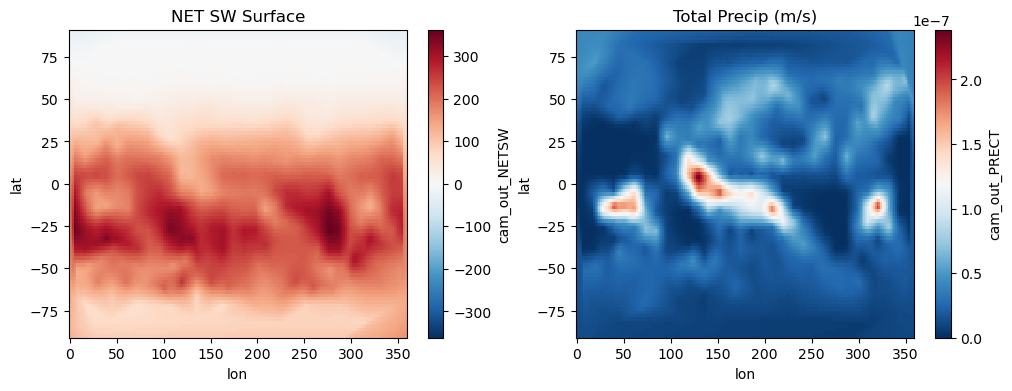

In [40]:
# plot the maps of these two variables at a specific time step

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_new['cam_out_NETSW'].isel(time=10).plot(cmap='RdBu_r',ax=ax[0])
ds_new['cam_out_PRECT'].isel(time=10).plot(cmap='RdBu_r',ax=ax[1])
ax[0].set_title('NET SW Surface')
ax[1].set_title('Total Precip (m/s)')

The maps looks smoother and more realistic.


## Now, analysis and visualization can be done using xarray
<span style="color:blue"> **Please use the plotting skills you learned to make the figures look well-annotated, nice and clear. Feel free to use ChatGPT if you have questions regarding the climate concepts.** </span>
    
### [Analysis 1] Time series and trend

We can use the original dataset to calculate the global mean time series. 

Note it should be the weighted average mean based on the area of each atmos grid/column. The unit for precipitation is m/s.

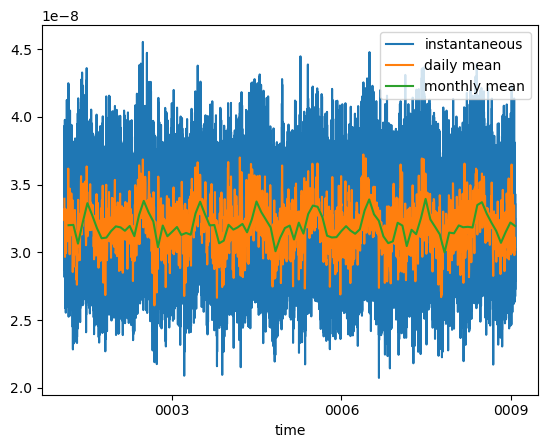

In [20]:
# here we use the data whose dimension size was not reduced
ds_origin = xr.merge([ds_grid, ds_origin])

# total precipitation = rainfall + snowfall
PRECT = ds_origin['cam_out_PRECC'] + ds_origin['cam_out_PRECSC']

# area-weighted global mean PRECT
# required concept: avg weights, broadcast, resampling
PRECT_mean = (PRECT * (ds_origin['area']/ds_origin['area'].sum())).sum('ncol')
PRECT_mean_daily = PRECT_mean.resample(time='1D').mean('time')
PRECT_mean_monthly = PRECT_mean.resample(time='1M').mean('time')

# visualization
fig, ax = plt.subplots()
PRECT_mean.plot(label='instantaneous', ax=ax)
PRECT_mean_daily.plot(label='daily mean', ax=ax)
PRECT_mean_monthly.plot(label='monthly mean', ax=ax)
ax.legend()

Or, we can use use the processed dataset on structured lat/lon coordinates. In this case, we need to calculate the area of each 2x2 degree grid. You'll only be able to show the time series of monthly mean data.

Please show the time series of global mean cam_out_NETSW using the processed dataset *ds_new* and we'll use this dataset for the rest analysis.

In [36]:
##### to be implemented...


Do you see a trend of the data? What else do you find with the time series?

### [Analysis 2] Histograms of global daily precipitation and radiation 

Show the statistical distribution of the variable values and simply describe what you see.


In [35]:
##### to be implemented...


### [Analysis 3] Climatology and Anomalies

#### 2D horizontal maps
Read **[What is Climatology?](https://drought.unl.edu/Education/DroughtIn-depth/WhatisClimatology.aspx)** and show the 2D maps of climatology status for total precipitation and surface net SW. 

Hint: it can be achieved by taking temporal mean.

In [42]:
##### to be implemented...


In [ ]:
Time series of anomalies of precipitation and radiation by year
2D lat-lon maps of anomalies for precipitation and radiation

Other than plotting the 2D maps, we can also plot curves of the zonal mean radiation/precipitation. 

#### Zonal mean climatology

Hint: Plot the curve along latitude, with x-axis as lat and y-axis as the zonnal mean variables. You can plot radiation and precipitation in two subplots or plot them together using **twin axes**.


In [ ]:
##### to be implemented...


### [Analysis 4] Seasonality

We've seen that the data exhibits strong seasonality/periods. We can further visualize it.


In [ ]:
Seasonal variation: x-axis: Jan Feb … Dec; y-axis: radiation
JJA (Jun Jul Aug) vs DJF (Dec Jan Feb) horizontal maps and their difference map (e.g. JJA minus DJF)


<span style="color:blue"> I only finished processing the 2D variables please follow the above cell and create an interpolated dataset for one or a few 3D variables with "lev" dimension </span>.
<span style="color:blue"> You do not need to show all the variables, use any of "state_t", "state_u" or "state_q0001" would be fine </span>.

### [Analysis 4] Vertical profiles of the 3D variables

Replace the *lev* dimension with *pressure*
<span style="color:blue"> Ask Sungduk about how to use P0 hyam hybm hybi hyai to calculate pressure. At this moment, you can ignore this task and just use "lev" as the vertical coordinate for the following tutorial</span>.


Analysis: Vertical structure for state variables state_t, state_u, … 
Mean vertical profiles of state_t, state_u, … from one grid (x: values of state_t, y: lev)
Mean vertical profiles of the state variables averaged in a domain [10S, 10N] (x: values of state_t, y: lev) [leave this for the students, Shreya does not need to do this]
lev-lat 2D plots of zonal mean state_t (x: lat, y: lev)
Lev-month plots of mean state_t (x-axis: month, y_axis: lev)


In [13]:
##### to be implemented...




### [Analysis 5] Other tasks
#### Practice of catorpy (plot any variable in any projection)

In [ ]:
##### to be implemented...


Spread of precipitation for each month. Plot curves indicating mean and shades indicating 1std values.


In [ ]:
##### to be implemented...


Change the data from xarray.dataset to dataframe and numpy matrix format and fit a linear regression between precip and radiation (you are not asked to tune the regression model for accuracy).


In [ ]:
##### to be implemented...


In [44]:
import gh_scoped_creds
%ghscopedcreds

<IPython.core.display.Javascript object>

The code 37BC-4C39 has been copied to your clipboard.
You have 15 minutes to go to https://github.com/login/device and paste it there.

Waiting......


Visit https://github.com/apps/leap-hub-push-access to manage list of repositories you can push to from this location
Tip: Use https:// URLs to clone and push to repos, not ssh URLs!


In [ ]:
use respect to